In [1]:
# imports
import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
#####################
# my files
# target model
from net_ import target_net
#from net_conv import target_net
# gan architectures
import gans_archs
# advgan training class
from GAN_ import advGAN

if torch.cuda.is_available():  
    dev = 'cuda:0'
else:  
    dev = 'cpu'

print('device: ', dev)

# functions
def transform_data(data_loader_obj):
    ims = []
    lls = []
    for imgs,lbls in data_loader_obj:
        for img,lbl in zip(imgs,lbls):
            ims.append(img)
            lls.append(lbl)
    ims = torch.stack(ims)
    lls = torch.stack(lls)
    return ims,lls

device:  cuda:0


In [2]:
# obtain mnist data and process
batch_size = 128
num_of_classes = 10

def get_indices(dataset,ind_array):
    indices =  []
    for i in range(len(dataset.targets)):
        for ind in ind_array:
            if dataset.targets[i] == ind:
                indices.append(i)
    return indices

dataset = MNIST('.', train=True, download=False,transform=transforms.ToTensor())
dataset_test = MNIST('.', train=False, download=False,transform=transforms.ToTensor())

idx = get_indices(dataset, np.arange(num_of_classes))
idx_test = get_indices(dataset_test, np.arange(num_of_classes))

data_loader_rftarget = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))
data_loader_target = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))
data_loader_gan = DataLoader(dataset, batch_size=batch_size, sampler = SubsetRandomSampler(idx))
data_loader_test = DataLoader(dataset_test, batch_size=1000, sampler = SubsetRandomSampler(idx_test))

classes = np.arange(num_of_classes)

In [3]:
# target model
n_estimators = 750
ims_train,lls_train = transform_data(data_loader_target)
rf = RandomForestClassifier(n_estimators=n_estimators)
#rf.fit(ims_train.reshape(len(ims_train),28*28).detach().numpy(),lls_train)
# save the model
PATH = './target_models/rf_model'+str(num_of_classes)+'classes'+'_nest'+str(n_estimators)+'.joblib'
#dump(rf, PATH) 
# load the model
rf = load(PATH)

# test random forest accuracy
ims_test,lls_test = transform_data(data_loader_test)
print('accuracy: ', accuracy_score(rf.predict(ims_test.reshape(len(ims_test),28*28).detach().numpy()),lls_test))

accuracy:  0.9723


In [12]:
# import gen/disc
gen = gans_archs.Generator1()#include_noise=True,device=dev)
disc = gans_archs.Discriminator1()

# arguments for GAN training 
#target_net, gen, disc,
tar_criterion=nn.CrossEntropyLoss()
criterion=nn.BCEWithLogitsLoss()
n_epochs=200
batch_size=128
lr=0.00001
display_step=500
gen_arch='cov'
###############################
gen_arch_num=1
disc_coeff=8.
hinge_coeff=.25
adv_coeff=3.
c=0.2
gen_path_extra='rftar_proba_genarch_'+str(gen_arch_num)
shape=(1,28,28)
num_of_classes=num_of_classes
################################

# initiate advgan
advgan = advGAN(rf.predict_proba,gen,disc,tar_criterion=tar_criterion,
                criterion=criterion,n_epochs=n_epochs,
                batch_size=batch_size,num_of_classes=num_of_classes,
                lr=lr,disc_coeff=disc_coeff,hinge_coeff=hinge_coeff,
                adv_coeff=adv_coeff,c=c,gen_path_extra=gen_path_extra,
                device=dev,display_step=display_step,shape=shape,gen_arch=gen_arch)

path:  ./advgan_models/rftar_proba_genarch_1_device_cuda:0_10classes_8p0disc_0p25hinge_0p2c_3p0adv.pt


epoch:  1
Step 500: Generator loss: 10.828038787980077, discriminator loss: 3.0420420441627494


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.7890625 | target model % correct: 1.0 | avg. frobenius norm: 4.227322578430176
gen loss:  10.474910658845863  | disc loss:  1.5873194932937622


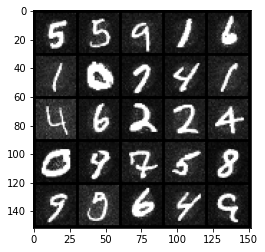

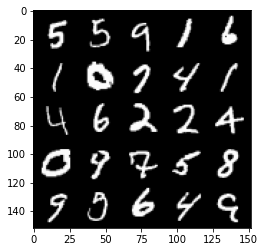

epoch:  2
Step 1000: Generator loss: 9.504891162173665, discriminator loss: 2.044276989936828


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.6640625 | target model % correct: 1.0 | avg. frobenius norm: 1.172452449798584
gen loss:  8.831746164333847  | disc loss:  2.766716241836548


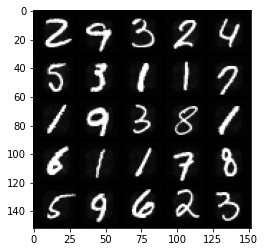

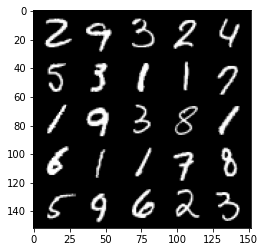

epoch:  3
Step 1500: Generator loss: 8.393277267519952, discriminator loss: 3.361401480197905


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.4609375 | target model % correct: 1.0 | avg. frobenius norm: 0.42179808020591736
gen loss:  8.219744549524952  | disc loss:  4.086472034454346


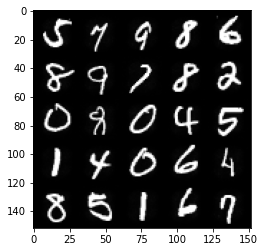

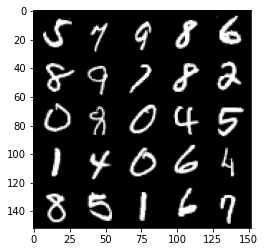

epoch:  4
Step 2000: Generator loss: 8.024854803481757, discriminator loss: 4.392585097789766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.359375 | target model % correct: 1.0 | avg. frobenius norm: 0.2235722690820694
gen loss:  7.9953861800212565  | disc loss:  4.742791652679443


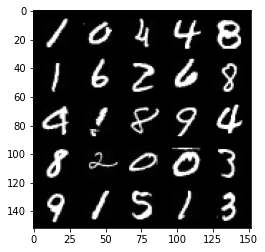

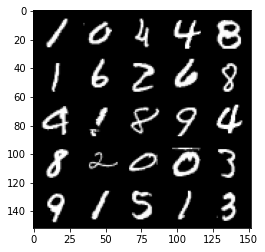

epoch:  5
Step 2500: Generator loss: 7.895493247753903, discriminator loss: 4.911653572082521


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.3515625 | target model % correct: 1.0 | avg. frobenius norm: 0.16581788659095764
gen loss:  7.815537278616603  | disc loss:  4.947368621826172


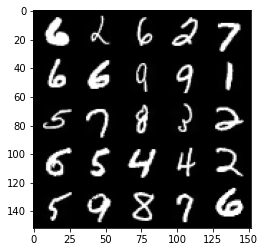

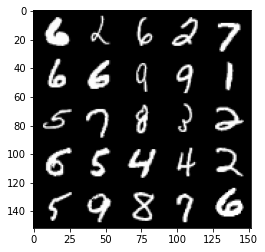

epoch:  6
Step 3000: Generator loss: 7.844306674989659, discriminator loss: 5.1475189361572316


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.2734375 | target model % correct: 1.0 | avg. frobenius norm: 0.1434638947248459
gen loss:  7.759394330877214  | disc loss:  5.264570236206055


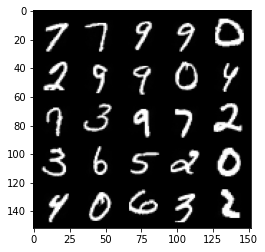

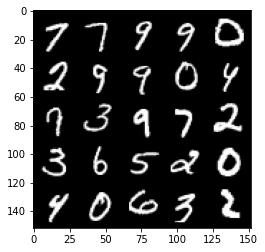

epoch:  7
Step 3500: Generator loss: 7.825714163806652, discriminator loss: 5.293879186630256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.1875 | target model % correct: 1.0 | avg. frobenius norm: 0.1393115520477295
gen loss:  7.784452038912333  | disc loss:  5.2430219650268555


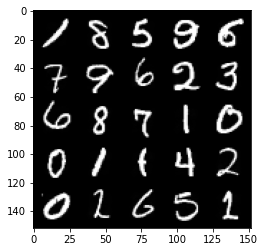

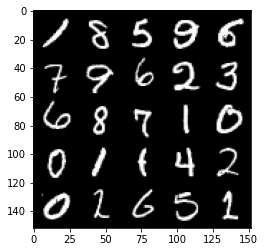

epoch:  8
Step 4000: Generator loss: 7.821371132368914, discriminator loss: 5.380814242362974


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


% wrong: 0.15625 | target model % correct: 1.0 | avg. frobenius norm: 0.13176822662353516
gen loss:  7.790937028697509  | disc loss:  5.350378036499023


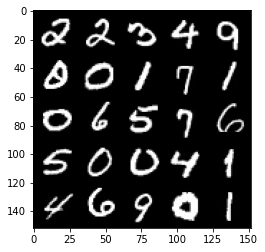

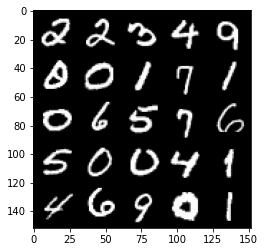

RuntimeError: [enforce fail at inline_container.cc:274] . unexpected pos 2514112 vs 2514008

In [13]:
%%time 
# train the gan
gen,disc = advgan.train(data_loader_gan)

In [ ]:
# notes
'''
When not concatenated with a noise vector, the robustness of the adv examples dies off. Results are illusrated 
in the form (epoch, % wrong, avg. frob. norm)
(5, 0.4, 4.4)
(25, 0.0, 0.29)
(40, 0.008, 0.15)
'''